In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### TFIDF

In [5]:
# train_logとtest_logを結合
log_df = pd.concat([train_log, test_log], sort=False)

# session_idごとにyad_noのリストを作成
session_yadno = log_df.groupby('session_id')['yad_no'].apply(list)
# session_yadnoがシリーズであるため、これをデータフレームに変換
session_yadno_df = session_yadno.reset_index(name='yadno_list')
session_yadno_df

,session_id,yadno_list
0,000007603d533d30453cc45d0f3d119f,[2395]
1,00001149e9c73985425197104712478c,"[3560, 1959]"
2,0000ca043ed437a1472c9d1d154eb49b,[13535]
3,0000d4835cf113316fe447e2f80ba1c8,[123]
4,0000e02747d749a52b7736dfa751e258,[11984]
...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989]
463394,ffffb1d30300fe17f661941fd085b04b,[6030]
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]"
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250]


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# yadno_listの各要素を文字列に変換
session_yadno_df['yadno_list_str'] = session_yadno_df['yadno_list'].apply(lambda x: ' '.join(map(str, x)))
# TF-IDFベクトルライザーの初期化
tfidf_vectorizer = TfidfVectorizer()
# yadno_list_str列にTF-IDF適用
tfidf_matrix = tfidf_vectorizer.fit_transform(session_yadno_df['yadno_list_str'])

# SVDの初期化（n次元に圧縮）
svd = TruncatedSVD(n_components=10, random_state=42)
# TF-IDF行列にSVDを適用
svd_matrix = svd.fit_transform(tfidf_matrix)
# 結果をデータフレームに追加
df_svd = pd.DataFrame(svd_matrix, columns=['SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10'])

In [7]:
df_svd

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,-6.464471e-11,2.891166e-10,-3.660432e-10,-2.273841e-09,4.557497e-10,-4.159497e-09,-3.617483e-09,-1.332808e-08,-4.444884e-09,1.270313e-09
1,-3.463665e-06,-1.040443e-05,1.113840e-05,5.396235e-05,-7.213978e-05,6.641731e-05,1.258993e-06,3.709086e-04,3.118969e-04,-4.967234e-04
2,-5.978426e-08,-1.443402e-07,-7.438694e-07,1.818956e-06,4.992683e-06,3.372735e-06,-1.433129e-05,-2.026925e-05,2.013084e-05,2.943140e-05
3,-7.211440e-10,-4.702864e-10,-5.611860e-09,8.650016e-09,-1.469571e-08,-2.666739e-08,-5.462518e-08,2.190828e-08,-4.270130e-08,-2.773235e-08
4,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513903e-04,-9.935870e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...
463393,-1.712871e-06,-3.114490e-06,-2.240175e-05,4.503927e-04,5.232237e-04,6.334056e-05,2.631516e-05,-6.399583e-05,-6.301694e-05,-7.216633e-05
463394,-1.193886e-05,-1.372870e-05,-6.676417e-05,5.990706e-05,-1.412355e-04,-1.268509e-04,1.693621e-04,1.087538e-04,8.125754e-05,4.445082e-04
463395,2.983724e-08,1.918855e-06,-4.454704e-07,-1.956480e-05,1.003507e-05,9.055934e-06,8.319464e-05,-7.836167e-05,7.000656e-05,8.072538e-05
463396,1.218515e-05,-2.288631e-06,2.281286e-05,-7.400448e-05,6.028529e-05,1.106127e-04,-8.938182e-04,9.540215e-04,-9.736649e-05,-1.681873e-04


In [8]:
# df_svdをsession_yadno_dfに結合
session_yadno_df = pd.concat([session_yadno_df, df_svd], axis=1)
session_yadno_df

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000007603d533d30453cc45d0f3d119f,[2395],2395,-6.464471e-11,2.891166e-10,-3.660432e-10,-2.273841e-09,4.557497e-10,-4.159497e-09,-3.617483e-09,-1.332808e-08,-4.444884e-09,1.270313e-09
1,00001149e9c73985425197104712478c,"[3560, 1959]",3560 1959,-3.463665e-06,-1.040443e-05,1.113840e-05,5.396235e-05,-7.213978e-05,6.641731e-05,1.258993e-06,3.709086e-04,3.118969e-04,-4.967234e-04
2,0000ca043ed437a1472c9d1d154eb49b,[13535],13535,-5.978426e-08,-1.443402e-07,-7.438694e-07,1.818956e-06,4.992683e-06,3.372735e-06,-1.433129e-05,-2.026925e-05,2.013084e-05,2.943140e-05
3,0000d4835cf113316fe447e2f80ba1c8,[123],123,-7.211440e-10,-4.702864e-10,-5.611860e-09,8.650016e-09,-1.469571e-08,-2.666739e-08,-5.462518e-08,2.190828e-08,-4.270130e-08,-2.773235e-08
4,0000e02747d749a52b7736dfa751e258,[11984],11984,4.135288e-04,-6.844452e-06,2.621962e-03,2.017062e-04,-2.268762e-04,8.729391e-04,1.513903e-04,-9.935870e-06,-7.057449e-04,-3.924756e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463393,ffff9a7dcc892875c7a8b821fa436228,[8989],8989,-1.712871e-06,-3.114490e-06,-2.240175e-05,4.503927e-04,5.232237e-04,6.334056e-05,2.631516e-05,-6.399583e-05,-6.301694e-05,-7.216633e-05
463394,ffffb1d30300fe17f661941fd085b04b,[6030],6030,-1.193886e-05,-1.372870e-05,-6.676417e-05,5.990706e-05,-1.412355e-04,-1.268509e-04,1.693621e-04,1.087538e-04,8.125754e-05,4.445082e-04
463395,ffffcd5bc19d62cad5a3815c87818d83,"[12230, 10619, 12230]",12230 10619 12230,2.983724e-08,1.918855e-06,-4.454704e-07,-1.956480e-05,1.003507e-05,9.055934e-06,8.319464e-05,-7.836167e-05,7.000656e-05,8.072538e-05
463396,ffffe984aafd6127ce8e43e3ca40c79d,[8250],8250,1.218515e-05,-2.288631e-06,2.281286e-05,-7.400448e-05,6.028529e-05,1.106127e-04,-8.938182e-04,9.540215e-04,-9.736649e-05,-1.681873e-04


In [9]:
session_yadno_df[session_yadno_df['session_id'] == '000104bdffaaad1a1e0a9ebacf585f33']

,session_id,yadno_list,yadno_list_str,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
7,000104bdffaaad1a1e0a9ebacf585f33,"[96, 898]",96 898,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071


In [10]:
session_yadno_df["SVD1"].value_counts().nunique() 

179

In [11]:
train_df = pd.merge(train_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')
test_df = pd.merge(test_df, session_yadno_df[['session_id', 'SVD1', 'SVD2', 'SVD3', 'SVD4', 'SVD5', 'SVD6', 'SVD7', 'SVD8', 'SVD9', 'SVD10']], on='session_id', how='left')

In [12]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,...,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,...,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,...,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,...,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,...,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,...,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714,-0.000002,-0.000001,-0.000017,0.000024,0.000003,0.000024,0.000023,-0.000042,-0.000092,-0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,...,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748,0.000012,-0.000121,0.000170,-0.000088,-0.000040,-0.000422,-0.002777,-0.001850,-0.007480,-0.001429
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,...,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177,0.000012,-0.000121,0.000170,-0.000088,-0.000040,-0.000422,-0.002777,-0.001850,-0.007480,-0.001429
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1

### LightGBM Ranker（candidate用のRankerモデル）

In [13]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')] # seen_yadも入れる
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# LightGBM のパラメータ
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [3, 5, 10],
    # 'label_gain':"0,1,5",　# ここを指定すると、ターゲットの重み付けができる　https://blog.recruit.co.jp/data/articles/lgbm_rank/
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators' : 5000,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

In [14]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score

map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # クエリごとのデータポイント数を計算
    train_groups = train_data.groupby(query_ids).size().values
    val_groups = valid_data.groupby(query_ids).size().values

    # LightGBMデータセットを作成
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
    lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(valid_data[features])
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7697
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 46
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752087	valid_0's map@5: 0.767551	valid_0's map@10: 0.784358
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751602	valid_0's map@5: 0.767267	valid_0's map@10: 0.783935
[3]	valid_0's map@3: 0.755759	valid_0's map@5: 0.771479	valid_0's map@10: 0.78759
[4]	valid_0's map@3: 0.755323	valid_0's map@5: 0.771099	valid_0's map@10: 0.787295
[5]	valid_0's map@3: 0.757006	valid_0's map@5: 0.772672	valid_0's map@10: 0.788698
[6]	valid_0's map@3: 0.758203	valid_0's map@5: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7700
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 46
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.749847	valid_0's map@5: 0.766123	valid_0's map@10: 0.782738
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.754289	valid_0's map@5: 0.77013	valid_0's map@10: 0.786428
[3]	valid_0's map@3: 0.755914	valid_0's map@5: 0.771489	valid_0's map@10: 0.787645
[4]	valid_0's map@3: 0.756567	valid_0's map@5: 0.77174	valid_0's map@10: 0.788111
[5]	valid_0's map@3: 0.757219	valid_0's map@5: 0.77259	valid_0's map@10: 0.7888
[6]	valid_0's map@3: 0.757213	valid_0's map@5: 0.772774	valid_0's map@10: 0.788848
[7]	valid_0's map@3: 0.756399	val

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7697
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 46
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747326	valid_0's map@5: 0.763674	valid_0's map@10: 0.780629
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.749641	valid_0's map@5: 0.765209	valid_0's map@10: 0.782382
[3]	valid_0's map@3: 0.750899	valid_0's map@5: 0.766402	valid_0's map@10: 0.783408
[4]	valid_0's map@3: 0.749739	valid_0's map@5: 0.765749	valid_0's map@10: 0.782537
[5]	valid_0's map@3: 0.752417	valid_0's map@5: 0.768405	valid_0's map@10: 0.784868
[6]	valid_0's map@3: 0.753076	valid_0's map@5: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7703
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 46
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750512	valid_0's map@5: 0.766234	valid_0's map@10: 0.783231
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751399	valid_0's map@5: 0.767024	valid_0's map@10: 0.78393
[3]	valid_0's map@3: 0.751935	valid_0's map@5: 0.767259	valid_0's map@10: 0.783988
[4]	valid_0's map@3: 0.753001	valid_0's map@5: 0.768196	valid_0's map@10: 0.784842
[5]	valid_0's map@3: 0.755186	valid_0's map@5: 0.770656	valid_0's map@10: 0.786993
[6]	valid_0's map@3: 0.75662	valid_0's map@5: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.260894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7697
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 46
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.748236	valid_0's map@5: 0.763985	valid_0's map@10: 0.781063
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751189	valid_0's map@5: 0.766387	valid_0's map@10: 0.783462
[3]	valid_0's map@3: 0.753732	valid_0's map@5: 0.768574	valid_0's map@10: 0.785328
[4]	valid_0's map@3: 0.75338	valid_0's map@5: 0.768797	valid_0's map@10: 0.78541
[5]	valid_0's map@3: 0.753819	valid_0's map@5: 0.769096	valid_0's map@10: 0.785651
[6]	valid_0's map@3: 0.753654	valid_0's map@5: 0.

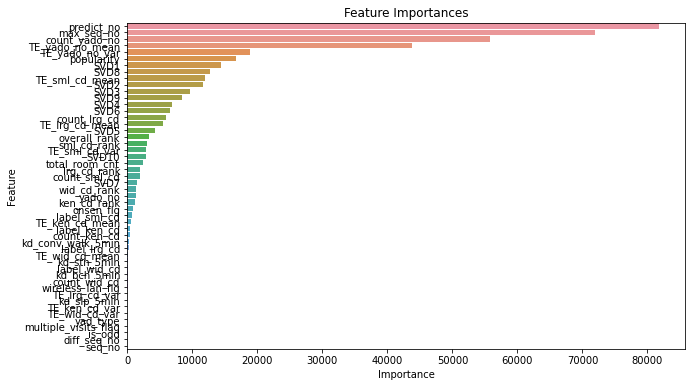

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importance(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [16]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [17]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.135148
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.062689
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.284210
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.578967
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.784885


In [18]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.135148
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.062689
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.284210
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.578967
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.784885
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.269331
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.486167
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.601079
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.586286


In [19]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.135148
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.062689
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.284210
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.578967
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.784885
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.269331
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.486167
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.601079
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.586286


In [20]:
# アンサンブル用にoof_predを保存
# oof_pred_df.to_csv('../ensemble/lgbRanker_ver10_oof_pred.csv', index=False)

In [21]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.135148
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.062689
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.284210
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.578967
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.784885
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.269331
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.486167
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.601079
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.586286


### CVの計算

In [22]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [23]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [25]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 5490, 1284, 254, 12491, 4072]
CPU times: user 742 µs, sys: 0 ns, total: 742 µs
Wall time: 664 µs


In [26]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:50<00:00, 5714.65it/s]


In [27]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,11882,5289,12846,997,3324,9207,9208,9209
1,8253,4488,8747,1586,3725,11104,2259,2570,8225,3564
2,9039,4863,7509,6722,2957,13642,4355,5238,1967,11724
3,626,2272,13549,755,11715,109,13296,7812,1341,7872
4,96,3894,7749,902,11380,5490,1284,254,12491,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,3725,10522,10955,5719,13717,2876,8677,1586
288694,2900,4767,399,8703,963,513,3940,8465,6654,5299
288695,2087,7308,7820,4040,4398,12240,10364,9558,3566,844
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [28]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [29]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [30]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [32]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0          True
1          True
2          True
3          True
4          True
          ...  
288693     True
288694     True
288695     True
288696    False
288697    False
Length: 288698, dtype: bool
一致していない行：
275454


In [33]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [34]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,11882,5289,12846,997,3324,9207,9208,9209
1,8253,4488,8747,1586,3725,11104,2259,2570,8225,3564
2,9039,4863,7509,6722,2957,13642,4355,5238,1967,11724
3,626,2272,13549,755,11715,109,13296,7812,1341,7872
4,96,3894,7749,902,11380,5490,1284,254,12491,4072
5,12544,4823,10510,5369,9207,9199,9201,1,9202,9200
6,12774,4574,7531,2480,441,13240,2282,7273,10442,10378
7,10544,9508,7681,12962,111,4744,12464,12125,10362,1755
8,899,3644,3802,13220,4014,9723,12432,2164,13702,1227
9,3278,10478,379,9773,3483,550,6592,2806,4303,9430


In [35]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [36]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [37]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4341764055193833


In [38]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [39]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [41]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,11882,5289,12846,997,3324,9207,9208,9209,False
1,8253,4488,8747,1586,3725,11104,2259,2570,8225,3564,False
2,9039,4863,7509,6722,2957,13642,4355,5238,1967,11724,False
3,626,2272,13549,755,11715,109,13296,7812,1341,7872,False
4,96,3894,7749,902,11380,5490,1284,254,12491,4072,False


### 推論用の候補テーブル作成

In [42]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [43]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.52841235 -0.35656486 -0.31370644 ... -0.34731339 -0.36978871
 -0.33677058]
1683604


In [44]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [45]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [46]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.528412
1,00001149e9c73985425197104712478c,4714,-0.356565
2,00001149e9c73985425197104712478c,2680,-0.313706
3,00001149e9c73985425197104712478c,4420,-0.909874
4,00001149e9c73985425197104712478c,5466,-0.811844


In [47]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.528412
1,00001149e9c73985425197104712478c,4714,-0.356565
2,00001149e9c73985425197104712478c,2680,-0.313706
3,00001149e9c73985425197104712478c,4420,-0.909874
4,00001149e9c73985425197104712478c,5466,-0.811844
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.332898
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.319461
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.347313
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.369789


In [48]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.528412
1,00001149e9c73985425197104712478c,4714,-0.356565
2,00001149e9c73985425197104712478c,2680,-0.313706
3,00001149e9c73985425197104712478c,4420,-0.909874
4,00001149e9c73985425197104712478c,5466,-0.811844
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.332898
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.319461
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.347313
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.369789


In [49]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.528412
1,00001149e9c73985425197104712478c,4714,-0.356565
2,00001149e9c73985425197104712478c,2680,-0.313706
3,00001149e9c73985425197104712478c,4420,-0.909874
4,00001149e9c73985425197104712478c,5466,-0.811844
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.332898
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.319461
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.347313
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.369789


In [50]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/lgbRanker_ver10_test_pred.csv', index=False)

In [51]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [53]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 1891, 11723, 3781, 12767, 5623, 12620, 867, 11994, 634]
CPU times: user 407 µs, sys: 0 ns, total: 407 µs
Wall time: 477 µs


In [54]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:28<00:00, 6202.98it/s]


In [55]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,4420,9830,9534,6563,5785
1,613,6129,7014,143,8108,11923,4066,6555,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,6730,13570
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746
4,10826,3476,3854,9020,12029,9623,2862,5372,3844,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,5744,7062,10997,2278,10042,3440,9743
174696,899,3802,4014,3644,1227,13220,9723,13702,2164,12432
174697,12939,13719,7308,2087,13797,11037,13241,8143,11796,5810
174698,3002,3100,2373,10287,2692,13672,1687,4976,5513,12281


In [56]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [57]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [58]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [59]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [60]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [61]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,4420,9830,9534,6563,5785,False
1,613,6129,7014,143,8108,11923,4066,6555,11237,12862,False
2,757,9190,7710,1774,9910,10485,6721,410,6730,13570,False
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746,False
4,10826,3476,3854,9020,12029,9623,2862,5372,3844,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,5744,7062,10997,2278,10042,3440,9743,False
174696,899,3802,4014,3644,1227,13220,9723,13702,2164,12432,False
174697,12939,13719,7308,2087,13797,11037,13241,8143,11796,5810,False
174698,3002,3100,2373,10287,2692,13672,1687,4976,5513,12281,False


In [62]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/lgbRanker_ver10.csv', index=False)